# Building Modelling SEM/SGB 07/06/2022
with Prof. Christian GHIAUS

Project members: Shariq NADEEM, Jana KADDOUR, Bram SEZGIN, Mikayel MARGARYAN, AL-Mu’tez billah AL-SQOUR

Disclaimer: Large parts of the python code and markdown explanations are directly copied from 🔗(https://github.com/cghiaus/dm4bem). Adaptations are made where necessairy.


In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Introduction

Buildings consume a significant amount of energy whether residential, commercial or industrial. Although the rate of consumption is different for each, one can agree that they all have contribution in the global climate change issue in a holistic view. Building energy management systems play a vital role to gain control of the building consumption and take appropriate measures for the reduction of energy consumption by a building.

Making buildings more energy efficient will contribute significantly to the EU achieving its energy and climate goals. But before going deep down further in efficiency improvement and energy management, a basic simulation and control strategy of a building model must be studied. A typical building simulation model has inputs from the building geometry, weather forecasts, internal heat gains from building occupants and equipment loads, heating, ventilation, and cooling (HVAC) system specifications. All these inputs are considered while performing this simulation modeling.
This report discusses the designing of a building model, undergone hypothesis, a classical thermal model, the mathematical model and the model implementation using Jupyter Python notebook. The results of steady state simulation, dynamic simulation and inside temperature control via optimization are also presented.


## Building Plan and Hypothesis

### Building Plan

The figure below presents the section view of the building chosen to be modelled. The following points describe the building:
- The studio designed has one window on the west side which is 5m long and this will allow the light coming through.
- The large room in the studio is mentioned as room A and consists of a wooden door (1m long) on the north side.
- The toilet is located at the south-east corner of the room and it is a 2m x 2m space called as room B. On the north side of room B there is a wooden door of length 2m.
- All the concrete external walls of the building are insulated (width = 16cm).
- The common/internal wall is made of concrete but is insulated.
- The external wall that separates outside and room A, is designated as wall A.
- The external wall that separates outside and room B, is designated as wall B.
- The height of all the concrete walls, all the insulations and all the wooden doors, irrespective of the living space or the toilet, is 2.5m.
- There are internal heat sources present such as a kitchen, lighting and occupants.


In [2]:
# Building dimensions
H = 2.5      # height of the room
La = 10      # length of external wall A
Lb = 4       # length of external wall B
L = 5        # building length
Lda = 1      # length of door A
Ldb = 2      # length of door B
Li = 2       # length of internal/common wall

W_wall = 0.15    # width/2 concrete 
W_glass = 0.01   # width/2 glass
W_ins = 0.08     # width/2 insulation
W_door = 0.5     # width/2 door

![smart_room_design](images/smart_room_design.png)

Below the properties of the different materials are given. Note that the outside walls consist of concrete and insulation, while the inside wall only contains concrete. The two doors in the model are made out of wood.

In [3]:
# Material parameters
air = {'Density': 1.2,'Specific heat': 1000} #  kg/m³, J/kg.K

cond_conc = 1.4     # conductivity concrete
cond_ins = 0.027    # conductivity insulation
cond_glass = 0.8    # conductivity glass
cond_wood = 0.02   # conductivity wood

wall = {'Density': [2300, 55, 2500, 650],        # kg/m³
        'Specific heat': [880, 1210, 750, 1700],  # J/kg.K
        'Conductivity': [cond_conc, cond_ins, cond_glass, cond_wood], # W/m.K
        'Width': [W_wall, W_ins, W_glass, W_door],
        'Height': [H, H, H, H]}
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass', 'Wood'])

At the outside and inside of the building there is convective heat transfer. To model this the following convection constants are defined.

In [4]:
# Convection
ho = 10      # convection coeff outside
hi = 4       # convection coeff inside

Inside the building there is also a HVAC unit which tries to control the inside temperature to a given setpoint. The HVAC unit is modelled as a proportional gain with respect to the difference between inside and outside temperature. (For verifying the steady state corectness Kp is initially set to zero)

In [5]:
# HVAC controller gain
Kp = 0 # 500 # P-Controller Gains

Below also the ventilation of the building is modelled, where ACH defines the air changes per hour.

In [6]:
# ventilation & advection
Va = L*L*H - Ldb*Li*H      # m³ volume of air
ACH = 1          # air changes per hour
Va_dot = ACH * Va / 3600    # m³/s air infiltration

### Hypothesis
To model the previously discussed building some simplifying assumptions are made:
- The top and bottom of the building are perfectly isolated, which means there are no heat flows through the roof or floor.
- Long wave radiation between the inner surfaces is neglected.
- All materials in the simulation are considered thermally linear.
- One dimensional heat transfer in a direction normal to the surface of the walls, door or window.
- Only diffuse radiation from the outside is exposed to the side of the building that has a window. The rest of the building is fully shaded and sees no light.

## Thermal Modelling

The figure below shows the thermal model of the building. In this thermal model, the whole model was divided in branches in order to have an accurate representation. In total there are eight branches. There are separate branches for the concrete wall A, door A and window for room A. One of the branches represent the ventilation that will occur through the window when it is opened. A separate branch represents the HVAC and the internal heat fluxes. Another branch represents the external wall B of room B. Finally, there are two branches that are common between the two rooms, one is the commonly shared wall and the other one is the door of room B.

All the nodes that represent a temperature and all the conductances that represent a flow are numbered. The building inertia is modelled by capacitances where necessairy in the model. Subsequently solar radiation sources are also added were added to better simulate optimal control of the internal building temperature. Due to the previously discussed hypothesis there is only diffuse light hitting the window. While partially absorbed, the largest part of this diffuse light is transmitted by the window and absorbed by the inside surface of wall A and the common wall.


![thermal_network](images/thermal_network.png)

The thermal circuit is discribed by the diferential-algebraic set of equations:

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
$$q = G (-A \theta + b)$$

where:
- **A** incidence matrix: shows how the temperature nodes are conected by branches of heat flow. It consists of $n_q$ rows and $n_{\theta}$ columns, where $n_q = 29$ is the number of flow branches and $n_{\theta} = 23$  is the number of temperature nodes. If flow *m* enters  into the node *n*, then the element (*m, n*) is 1; if flow *m* exits from the node *n*, then the element (*m, n*) is -1; if flow *m* is not conected to node *n*, then the element (*m, n*) is 0.

- **G** conductance matrix: diagonal matrix containing the conductances. Its size is It consists of $n_q \times n_q$,  where $n_q$ is the number of flow branches.

- **b** temperature source vector: denotes the temperature sources connected to the branch. If there is no temperature source on the branch *m*, then $b_m = 0$.

- **C** capacity matrix: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- **f** heat flow source vector: represents any sort of heat flux source connected to a node. If there is no heat flow source in the node *n*, then $f_n = 0$.

- **$\theta$** represents the temperature vector containing the temperature at each node.

### Incidence Matrix
The construction of the incidence matrix **A** is critical as a wrong value will produce nonsensical results such as negative temperature values when only positive temperature sources are present. In the code below each branch of the previously discussed thermal model is defined. For constructing the incidence matrix, all flows from 0 to 22 are modelled from left to right while the flows from 22 to 28 are modelled from right to left.

In [7]:
A = np.zeros([29,23])

# -- Wall A
A[0,0] =  1
A[1,0] = -1

A[1,1] =  1
A[2,1] = -1

A[2,2] =  1
A[3,2] = -1

A[3,3] =  1
A[4,3] = -1

A[4,4] =  1
A[5,4] = -1

# -- External door A
A[6,6] =  1
A[7,6] = -1

A[7,7] =  1
A[8,7] = -1

A[8,8] =  1
A[9,8] = -1

# -- Window
A[10,9] =   1
A[11,9] =  -1

A[11,10] =  1
A[12,10] = -1

# -- Zone A
A[5,5] =  1
A[9,5]=   1
A[12,5]=  1
A[13,5]=  1
A[14,5]=  1
A[15,5]= -1
A[19,5]= -1

# -- Internal door B
A[19,11] =  1
A[20,11] = -1

A[20,12] =  1
A[21,12] = -1

A[21,13] =  1
A[22,13] = -1

# -- Internal/Common wall
A[15,14] =  1
A[16,14] = -1

A[16,15] =  1
A[17,15] = -1

A[17,16] =  1
A[18,16] = -1

# -- Wall B
A[23,22] =  1
A[24,22] = -1

A[24,21] =  1
A[25,21] = -1

A[25,20] =  1
A[26,20] = -1

A[26,19] =  1
A[27,19] = -1

A[27,18] =  1
A[28,18] = -1

# -- Zone B
A[22,17] = 1
A[18,17] = 1
A[28,17]=  1

### Conductance Matrix
In the conductance matrix **G** all the conduction, convection and advection heat transfer phenomena are modelled. Also the proportional gain of the HVAC is included. Every diagonal element of the conductance matrix represents a conductance in the thermal model discussed before. Therefore the dimension of G is 29 by 29.

In [8]:
# G_Matrix
g = np.zeros(29)

g[0] = ho*La*H
g[1] = La*H*cond_conc/W_wall
g[2] = La*H*cond_conc/W_wall
g[3] = La*H*cond_ins/W_ins
g[4] = La*H*cond_ins/W_ins
g[5] = hi*La*H

g[6] = ho*Lda*H
g[7] = Lda*H*cond_wood/W_door
g[8] = Lda*H*cond_wood/W_door
g[9] = hi*Lda*H

g[10] = float(1/((1/(ho*L*H)) + (1/(L*H*cond_glass/W_glass)))) # window
g[11] = L*H*cond_glass/W_glass
g[12] = hi*La*H # window

g[13] = Va_dot * air['Density'] * air['Specific heat']
g[14] = Kp

g[15] = hi*Li*H
g[16] = Li*H*cond_conc/W_wall
g[17] = Li*H*cond_conc/W_wall
g[18] = hi*Li*H

g[19] = hi*Lb*H
g[20] = Lb*H*cond_wood/W_door
g[21] = Lb*H*cond_wood/W_door
g[22] = hi*Lb*H

g[23] = ho*Lb*H
g[24] = Lb*H*cond_conc/W_wall
g[25] = Lb*H*cond_conc/W_wall
g[26] = Lb*H*cond_ins/W_ins
g[27] = Lb*H*cond_ins/W_ins
g[28] = hi*Lb*H

G = np.diag(g)

### Capacitance Matrix
The capacitance matrix **C** represents the thermal inertia of the walls, window and doors. The dimension of the capacitance matrix is 23 by 23, as each diagonal entry reprensents the inertia of a temperature node.

In [9]:
# C_matrix
C = wall['Density'] * wall['Specific heat'] * wall['Height'] * wall['Width']
C['Air'] = air['Density'] * air['Specific heat'] * Va

c = np.zeros(23)
c[1] = C['Concrete'] * La
c[3] = C['Insulation'] * La
c[5] = C['Air']
c[7] = C['Wood'] * Lda
c[9] = C['Glass'] * L
c[12] = C['Wood'] * Ldb
c[15] = C['Concrete'] * Li
c[17] = C['Air']
c[19] = C['Insulation'] * Lb
c[21] = C['Concrete'] * Lb

C = np.diag(c)

### Input Vector
The vector of temperature sources **b** is the size of the number of branches here 29. All outside temperature sources of the model are set to 10°C while the internal setpoint temperature for the HVAC is set to 20°C. 

In [10]:
T_out = 10;
T_isp = 20;
b = np.zeros(29)
b[0]  = T_out
b[6]  = T_out
b[10] = T_out
b[13] = T_out
b[14] = T_isp
b[23] = T_out


The vector of heat sources is **f**. It has the size of the number of nodes (here 23) and its element corresponding to a node without a heat source is zero. For the steady state modelling all the sources are set to zero to be able to verify the correctness of the modelling, which is explained later in the notebook (see state-space model).

In [11]:
Q_a = 0 # internal sources
phi_s = np.array([0, 0, 0]) # outdoor radiative heat flow

f = np.zeros(23)
f[[4, 5, 9, 14]] = np.array([phi_s[0], Q_a, phi_s[1], phi_s[2]])

The *vector of outputs* is **y**. It has the size of the number of nodes (here 23). The non-zero values of **y** indicate the nodes that are the outputs of the model. Let's assume that all temperatures are of interest so that the model can be verified in a later stage (see state-space model).
The *vector of inputs* **u** is:

$$\mathbf{u} = \begin{bmatrix}
\mathbf{b}\\ 
\mathbf{f}
\end{bmatrix}$$

where **b** is  the vector of temperature sources and **f** the vector of heat flow sources. Note that in Python, a vector is a row. The **u** vector is obtained as an horizontal stack of the sources that are in the circuit (non-zero elements of **b** and **f**):

In [12]:
y = np.ones(23)
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

## State-Space Model

The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) of the dynamic model is obtained from the differential-algebraic set of equations:

In [13]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

Let's compare the steady state results obtained with the differential-algebraic equations of the thermal circuit:
$$y_{tc} = (A^T G A)^{-1}(A^T G b + f)$$
and the state-space:
$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$ 

In [14]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10.]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10.]
Max error in steady-state between thermal circuit and state-space: 1.48e-12


There are 2 important conclusions that can be made from the result shown above:
1. The numerical accuracy of both approaches is high as the numerical difference between two different computation methods yields the same result up to a high precision.
2. All the temperature nodes of the model are equal to the outside temperature (in this case 10°C). This is the case because the HVAC proportional constant and other external heat flow sources are set to zero. Logically every temperature of the building must then be equal to the outside temperature. This result gives confidence that the previously constructed matrices are correct.

## Dynamic Simulation
In dynamic simulation, the inputs vary in time. The sources are indicated by ones

In [15]:
b = np.zeros(29)
b[[0, 6, 10, 13, 14, 23]] = 1

f = np.zeros(23)
f[[4, 5, 9, 14]] = 1

Let's consider that the output of the circuit is the indoor temperature of the largest room (i.e. the temperature of node 5):

In [16]:
y = np.zeros(23)
y[[5]] = 1

The state-space representation is obtained from the differential-algebraic equations of the thermal circuit:

In [17]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

### Time Step
The maximum time step for numerical stability of Euler explicit integration in time is given by the minimum eigenvalue $\lambda$ of the state matrix $A_s$:

$$ \Delta t \leq \min (-2 / \lambda_i) = \min T_i/2$$

where $T_i$ is the time constants, $T_i = - \frac{1}{\lambda_i} $

In [18]:
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 821.59 s


The maximum time step for numerical stability of Euler explicit integration in time depends on the value of the P-controller.
- For a free floating building with **Kp = 0**, the maximal time step is **821.59s**.
- For **Kp = 500**, the time step is **198.56s**.

Consequently **dt = 100s** is chosen so that the explicit Euler integration is stable for both cases. For even larger values of Kp, the time step for explicit Euler stability further decreases. This is because for high values of Kp the building becomes a fast dynamic system. To integrate these fast dynamics the time step should also be small.

In [19]:
dt = 100

### Step Response
Let's obtain the dynamic response of the system to a step input. For the duration of simulation:

In [20]:
duration = 3600*24*3

the number of steps is:

In [21]:
n = int(np.floor(duration / dt))

The time vector (with time step `dt`) is

In [22]:
t = np.arange(0, n * dt, dt)    # time

For the input vector **u**, the outdoor temperatures are set to `To = 1`, the indoor set-point temperature is `Tsp = 1`, and the heat flow sources are zero. Note that for a nonzero Kp the system will act much faster to a temperature step. This is expected because the HVAC tries to equalize the inside and setpoint temperature.

In [23]:
# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To To Tsp To Phi_s0 Qa Phi_s1 Phi_s2]
u = np.zeros([10, n])
u[0:6, :] = np.ones([6, n])

The vectors for the evolution of temperatures (states) in time for Euler **exp**licit and **imp**licit are:

In [24]:
temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

By integrating the state-space model
$$\left\{\begin{array}{rr}
\dot{\theta}=A_s \theta + B_s u\\ 
y = C_s \theta + D_s u
\end{array}\right.$$
by using Euler forward (or explicit)
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
and Euler backward (or implicit) integration
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [25]:
I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

The following outputs are obtained:

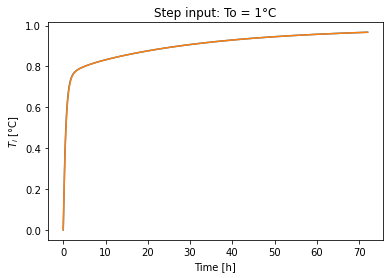

In [26]:
y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u 

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To = 1°C')
plt.show()

The first part of the curve where there is a rapid temperature increase is due to the ventilation. If the outside temperature changes and this air comes into the building, the inside temperature is quickly affected. The second part of the curve, where the indoor temperature increases more slowly, is affected by the slower reacting thermal mass of the building.

Also note that the explicity euler integration is stable, which is due to the earlier choice of a stable time step. If an unstable timestep is chosen, the explicit Euler integrated solution will be unstable and oscillate increasingly. The implicit Euler integrated solution is always stable, however this stability cannot be confused by the accuracy of the solution. For large timesteps, the implicit Euler solution degrades.


In [27]:
b = np.zeros(29)
b[[0, 6, 10, 13, 14, 23]] = 1
f = np.zeros(23)

ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[6]:.4f} °C')
print(f'- response to step input:{float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 1.0000 °C
- response to step input:0.9673 °C


### Simulation with Weather Data

Read the hourly weather data file from start date to end date. 
The data are for one month in the year 2000 (the choice of the year and month is arbitrary).

In [28]:
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-05-03 12:00:00'
end_date = '2000-06-05 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

From weather data, calculate the hourly solar radiation on a tilted surface, `Φt1` [W]. Note that only diffuse radiation is taken into account.

In [29]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1['diffuse']


The weather data is at the time-step of 1h. It needs to be at time step of `dt`. The outside temperature is `To`

In [30]:
data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})


Let's consider the indoor temperature setpoint `Tisp` and auxiliary heat flow `Qa` constant for the whole simulation period. Note that a part of the diffuse light `Φs1` is absorbed by the glass , while the other part of the light `Φs0` and `Φs2`is transmitted by the glass and absorbed by the different walls.

In [31]:
α_gSW = 0.1 # short wave glass absortivity
α_wSW = 0.2 # shart wave absortivity white surface
τ_gSW = 0.83 # short wave glass transmitance
Tisp = 20 # HVAC inside temperature setpoint
Qa = 0 # iside building heat generation
data['Tisp'] = Tisp * np.ones(data.shape[0]) 
data['Qa'] = Qa * np.ones(data.shape[0])
data['Φs0'] = data['Φt1']* τ_gSW * α_wSW * (L-Li) * H # on wall A
data['Φs1'] = data['Φt1']* α_gSW * L * H # on glass
data['Φs2'] = data['Φt1']* τ_gSW * α_wSW * Li * H # on internal/common wall

The simulation time vector, at time step `dt`is:

In [32]:
t = dt * np.arange(data.shape[0])

The input vector is formed by the temperature sources $\left [ T_o, T_o , T_o, T_o, T_{i,sp}, T_o \right ]$ and the heat flow sources $\left [ \Phi_{s0}, \dot{Q_a}, \Phi_{s1}, \Phi_{s2} \right ]$

In [33]:
u = pd.concat([data['To'], data['To'], data['To'], data['To'], data['Tisp'], data['To'], data['Φs0'], data['Qa'], data['Φs1'], data['Φs2']], axis=1)

The initial value of the state-vector can be different of zero:

In [34]:
temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

Explicit Euler integration in time
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$

In [35]:
for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which the variation of the output is obtained (i.e. indoor temperature):
$$y = C_s \theta + D_s u$$
and the variation of the heat flow of the HVAC system:
$$q_{HVAC} = K_p (T_{i,sp} - y)$$
where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

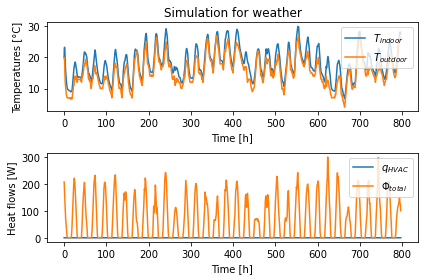

In [36]:
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Tisp'] - y_exp[0, :])

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

In the figure above the temperature in a free floating building with **Kp = 0** is shown. Because there is no influence from the HVAC, the indoor temperature follows the temperature of the outside. However it can be noted that the indoor temperature goes slightly higher than the outdoor temperature. This can be explained by the influence of the diffuse radiation that hits on the window and on the inside of the walls.

In the figure below the temperature in a climate controlled building with **Kp = 500** is shown. Here the HVAC tries to keep the indoor temperature at the temperature setpoint **Tisp = 20°C**. For even higher values of Kp, the indoor temperature will folow the setpoint closer. However, note that for higher values of Kp, (as discussed before), the stable timestep of the explicit Euler integration is smaller. In the figure below it is also visible that the HVAC can provide heat flows in both directions. When Tout > Tisp, the HVAC removes heat from the inside and when Tout < Tisp, the HVAC provides heat to the building.

![hvac_controlled](images/hvac_controlled.png)

## Conclusion

In this report the temperature modelling of a building was conducted. First, the building plan and possible modelling hypothesis were stated. Subsequently, the thermal model was constructed by modelling the different heat branches of the building. Also a HVAC and solar sources were added to the thermal model. From this model, the used material properties and the building dimensions, all the relevant matrices were constructed. In the following part of the report, the algebraic equations were transformed to a state space model, from which the steady state building temperatures were calculated. This steady state result, gave confidence that the constructed thermal matrices were correct. 

In a next stage two dynamic simulations were shown. The first one by applying a step input to the outside temperature and the second one by modelling real temperature and solar data. From the first dynamic simulation, it was concluded that initially the inside temperature reacts fast to outside variations. However, afterwards the indoor temperature rises much more slowly due to the thermal inertia of the building. From the second dynamic simulation, the effect of indoor climate control with HVAC was shown.